<a href="https://colab.research.google.com/github/chengnanyimeng/blockchain_analysis/blob/main/decentralization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import pandas as pd
from datetime import date, timedelta
from tqdm import tqdm
import numpy as np
import pytz
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [53]:
import matplotlib.pyplot as plt

# List all available Matplotlib styles
print(plt.style.available)

# Set the style to 'seaborn-white' for a clean look
plt.style.use('seaborn-white')

# Set font and font size globally using rcParams
plt.rcParams.update({
    'font.family': 'DejaVu Serif',  # Set the font family to DejaVu Serif
    'font.size': 10,  # Set the font size to 10 for better readability in two-column formats
    'text.color': 'black',  # Ensure text color is black for better contrast
    'axes.facecolor': 'white',  # Set the axes background color to white
    'figure.facecolor': 'white',  # Set the figure background color to white
    'axes.edgecolor': 'black',  # Set the axes edge color to black
})

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


<ipython-input-53-0fecd1474f1c>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [54]:
data = pd.read_csv('https://raw.githubusercontent.com/chengnanyimeng/blockchain_analysis/main/Algorand_data/al_block_data_proposercount_reward.csv')


In [55]:
data

,"{""date"":""2019-07-01""}",32,0
0,"{""date"":""2019-07-02""}",31,0
1,"{""date"":""2019-07-03""}",32,0
2,"{""date"":""2019-07-04""}",32,0
3,"{""date"":""2019-07-05""}",31,0
4,"{""date"":""2019-07-06""}",31,0
...,...,...,...
1417,"{""date"":""2023-05-19""}",70,0
1418,"{""date"":""2023-05-20""}",71,0
1419,"{""date"":""2023-05-21""}",68,0
1420,"{""date"":""2023-05-22""}",70,0


In [56]:
def gini(df):
    """
    Compute Gini coefficient of a DataFrame with a 'value' column
    """
    # Check if the DataFrame is empty or the 'value' column does not exist
    if df.empty or 'proposer_count' not in df.columns:
        return None
    # Extract the 'value' column and convert it to a sorted list
    values = sorted(df['proposer_count'].tolist())
    # Check if the list is empty
    if len(values) == 0:
        return None
    # Compute the cumulative sum of the values
    cum_values = [0] + list(pd.Series(values).cumsum())
    n = len(values)
    # Calculate Gini coefficient using the formula
    numer = sum([(i+1) * values[i] for i in range(n)])
    denom = n * sum(values)
    if denom == 0:
        return None  # Avoid division by zero
    gini = (2 * numer) / denom - (n + 1) / n
    return gini

def nakamoto(df):
    df.sort_values(by=['proposer_count'],ascending=False,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index(keys=df.index.values+1,inplace=True)
    df['prop'] = df['proposer_count']/df['proposer_count'].sum()
    df['cumprop'] = df['prop'].cumsum(axis=0)
    try:
        V = df[df['cumprop'] > 0.5].index[0]
        return V
    except:
        return 0

In [57]:
import math

# Define a function to calculate Shannon entropy for given proposer count
def calculate_entropy(proposer_count):
    if proposer_count == 0:
        return 0
    # Calculate the probability distribution for the proposer count
    probabilities = [1/proposer_count] * proposer_count
    # Calculate the Shannon entropy
    entropy = -sum(p * math.log2(p) for p in probabilities)
    return entropy

# Extract dates and proposer counts
data.columns = ['date', 'proposer_count', 'reward']  # Rename columns for clarity
data['date'] = data['date'].apply(lambda x: eval(x)['date'])  # Convert string to dictionary and then extract date

# Drop the 'reward' column as it is not needed
data = data.drop(columns=['reward'])

# Calculate the Shannon entropy for each day
data['entropy'] = data['proposer_count'].apply(calculate_entropy)
data

,date,proposer_count,entropy
0,2019-07-02,31,4.954196
1,2019-07-03,32,5.000000
2,2019-07-04,32,5.000000
3,2019-07-05,31,4.954196
4,2019-07-06,31,4.954196
...,...,...,...
1417,2023-05-19,70,6.129283
1418,2023-05-20,71,6.149747
1419,2023-05-21,68,6.087463
1420,2023-05-22,70,6.129283


We can also transform the daily data to weekly data.

In [60]:
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)
# Resample the data to weekly frequency, summing the 'entropy' values
weekly_data = data['entropy'].resample('W').sum()

# Create a new DataFrame
weekly_data = weekly_data.to_frame(name='entropy')

weekly_data = weekly_data.reset_index()
weekly_data.columns =[ 'date', 'entropy']
weekly_data

,date,entropy
0,2019-07-07,29.950052
1,2019-07-14,35.645384
2,2019-07-21,35.897906
3,2019-07-28,36.016924
4,2019-08-04,36.263197
...,...,...
199,2023-04-30,43.980433
200,2023-05-07,43.313212
201,2023-05-14,43.531510
202,2023-05-21,43.255917


In [61]:
data

,proposer_count,entropy
date,,
2019-07-02,31,4.954196
2019-07-03,32,5.000000
2019-07-04,32,5.000000
2019-07-05,31,4.954196
2019-07-06,31,4.954196
...,...,...
2023-05-19,70,6.129283
2023-05-20,71,6.149747
2023-05-21,68,6.087463


In [62]:
data.to_csv('entropy.csv', index=False)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


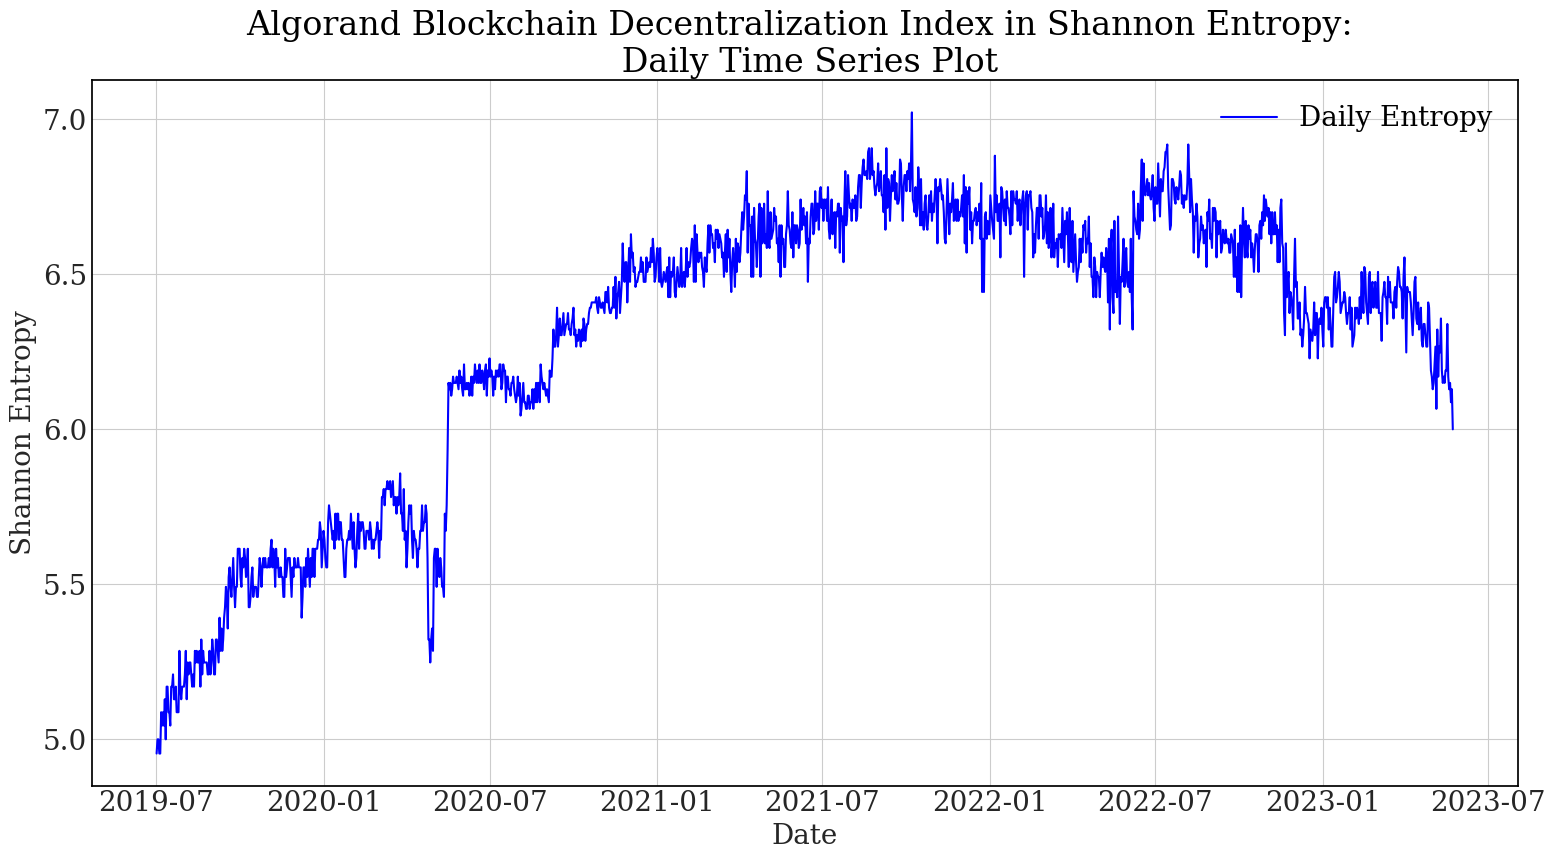

<Figure size 640x480 with 0 Axes>

In [63]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert the 'date' column to datetime
#data['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
#data.set_index('date', inplace=True)

# Set the style to a scientific publication style
import matplotlib.pyplot as plt

# List all available Matplotlib styles
print(plt.style.available)

# Set the style to 'seaborn-white' for a clean look
plt.style.use('tableau-colorblind10')

# Set font and font size globally using rcParams
plt.rcParams.update({
    'font.family': 'DejaVu Serif',  # Set the font family to DejaVu Serif
    'font.size': 20,  # Set the font size to 10 for better readability in two-column formats
    'text.color': 'black',  # Ensure text color is black for better contrast
    'axes.facecolor': 'white',  # Set the axes background color to white
    'figure.facecolor': 'white',  # Set the figure background color to white
    'axes.edgecolor': 'black',  # Set the axes edge color to black
})


# Create the time series plot
plt.figure(figsize=(16, 9))
plt.plot(data.index, data['entropy'], label='Daily Entropy',color='blue')

# Customize the plot
plt.title('Algorand Blockchain Decentralization Index in Shannon Entropy: \n Daily Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Shannon Entropy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('Algorand_entropy.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()
plt.tight_layout()
plt.show()

In [64]:
bc_data = pd.read_csv('https://raw.githubusercontent.com/chengnanyimeng/blockchain_analysis/main/Beacon_chain_data/validator_data.csv')
bc_data

,Timestamp,Value
0,1606780800000,21063
1,1606867200000,21339
2,1606953600000,22238
3,1607040000000,23128
4,1607126400000,24027
...,...,...
1003,1693440000000,762949
1004,1693526400000,765130
1005,1693612800000,767067
1006,1693699200000,769382


In [67]:
def calculate_entropy(value):
    if value == 0:
        return 0
    # Calculate the probability distribution for the proposer count
    probabilities = [1/value] * value
    # Calculate the Shannon entropy
    entropy = -sum(p * math.log2(p) for p in probabilities)
    return entropy
# Calculate the Shannon entropy for each day
bc_data['entropy'] = bc_data['Value'].apply(calculate_entropy)

In [69]:
bc_data.set_index('Timestamp', inplace=True)
bc_data

,Value,entropy
Timestamp,,
1606780800000,21063,14.362423
1606867200000,21339,14.381205
1606953600000,22238,14.440739
1607040000000,23128,14.497353
1607126400000,24027,14.552369
...,...,...
1693440000000,762949,19.541227
1693526400000,765130,19.545345
1693612800000,767067,19.548993


<ipython-input-71-a1fbfb5329cc>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


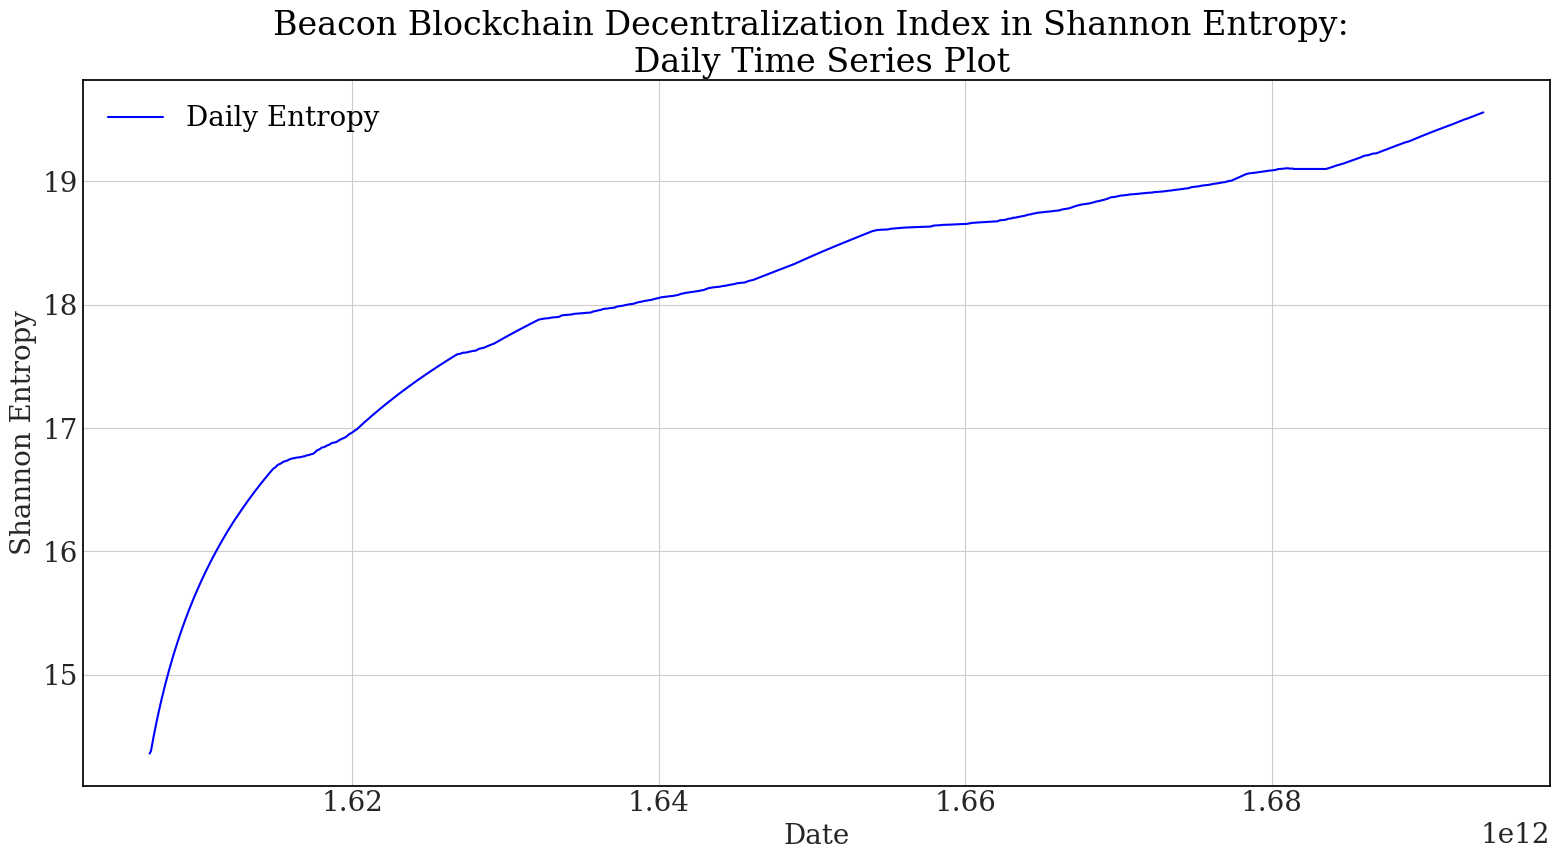

<Figure size 640x480 with 0 Axes>

In [71]:
# Set the style to a scientific publication style
# Set font and font size globally using rcParams
# Set the style to 'seaborn-white' for a clean look
plt.style.use('seaborn-white')
plt.rcParams.update({
    'font.family': 'DejaVu Serif',  # Set the font family to DejaVu Serif
    'font.size': 20,  # Set the font size to 10 for better readability in two-column formats
    'text.color': 'black',  # Ensure text color is black for better contrast
    'axes.facecolor': 'white',  # Set the axes background color to white
    'figure.facecolor': 'white',  # Set the figure background color to white
    'axes.edgecolor': 'black',  # Set the axes edge color to black
})


# Create the time series plot
plt.figure(figsize=(16, 9))
plt.plot(bc_data.index, bc_data['entropy'], label='Daily Entropy',color='blue')

# Customize the plot
plt.title('Beacon Blockchain Decentralization Index in Shannon Entropy: \n Daily Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Shannon Entropy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('Beacon_entropy.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()
plt.tight_layout()
plt.show()



In [13]:
al_transactions = pd.read_csv('https://raw.githubusercontent.com/chengnanyimeng/blockchain_analysis/main/Algorand_data/al_transac_data_count_fee.csv')

In [14]:
# Extract dates and proposer counts
al_transactions.columns = ['date', 'value', 'reward']  # Rename columns for clarity
al_transactions['date'] = al_transactions['date'].apply(lambda x: eval(x)['date'])  # Convert string to dictionary and then extract date

# Drop the 'reward' column as it is not needed
al_transactions = al_transactions.drop(columns=['reward'])

In [15]:
al_transactions['entropy'] = al_transactions['value'].apply(calculate_entropy)

<ipython-input-76-fa62ed1f599a>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


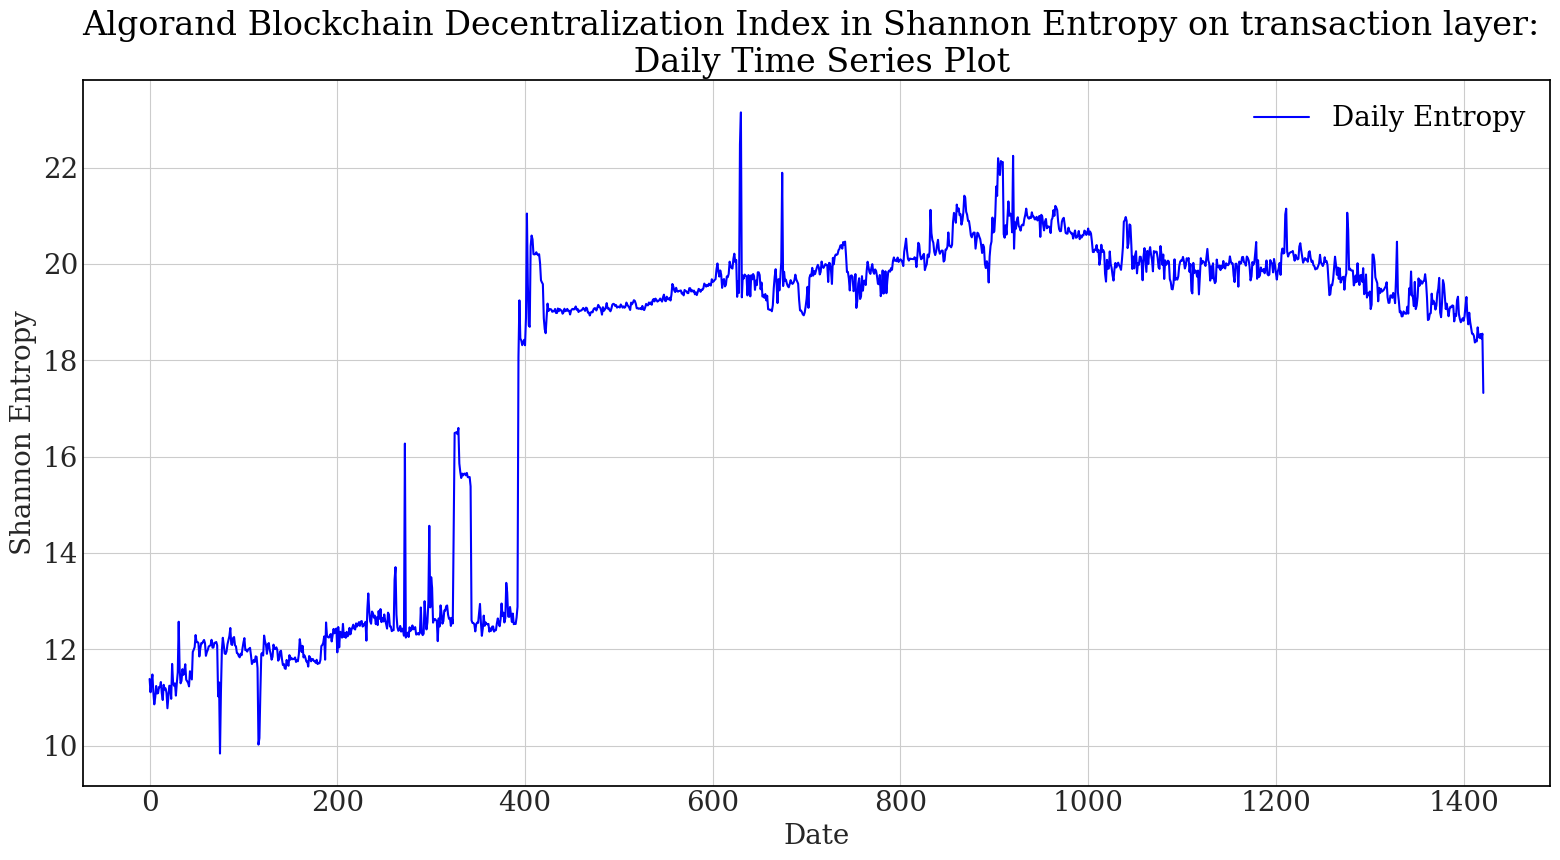

<Figure size 640x480 with 0 Axes>

In [76]:
#al_transactions.set_index('date', inplace=True)

# Set the style to a scientific publication style
# Set font and font size globally using rcParams
plt.style.use('seaborn-white')
plt.rcParams.update({
    'font.family': 'DejaVu Serif',  # Set the font family to DejaVu Serif
    'font.size': 20,  # Set the font size to 10 for better readability in two-column formats
    'text.color': 'black',  # Ensure text color is black for better contrast
    'axes.facecolor': 'white',  # Set the axes background color to white
    'figure.facecolor': 'white',  # Set the figure background color to white
    'axes.edgecolor': 'black',  # Set the axes edge color to black
})

# Create the time series plot
plt.figure(figsize=(16, 9))
plt.plot(al_transactions.index, al_transactions['entropy'], label='Daily Entropy',color='blue')

# Customize the plot
plt.title('Algorand Blockchain Decentralization Index in Shannon Entropy on transaction layer: \n Daily Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Shannon Entropy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('Algorand_transaction_entropy.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()
plt.tight_layout()
plt.show()

In [80]:
be_transact = pd.read_csv('https://raw.githubusercontent.com/chengnanyimeng/blockchain_analysis/main/Beacon_chain_data/daily_transactions.csv')
be_transact['entropy'] = be_transact['Value'].apply(calculate_entropy)

In [81]:
be_transact

,Timestamp,Value,entropy
0,1438214400000,0,0.000000
1,1438300800000,0,0.000000
2,1438387200000,0,0.000000
3,1438473600000,0,0.000000
4,1438560000000,0,0.000000
...,...,...,...
2950,1693440000000,1010343,19.946414
2951,1693526400000,1005894,19.940047
2952,1693612800000,1024199,19.966065
2953,1693699200000,1039218,19.987067


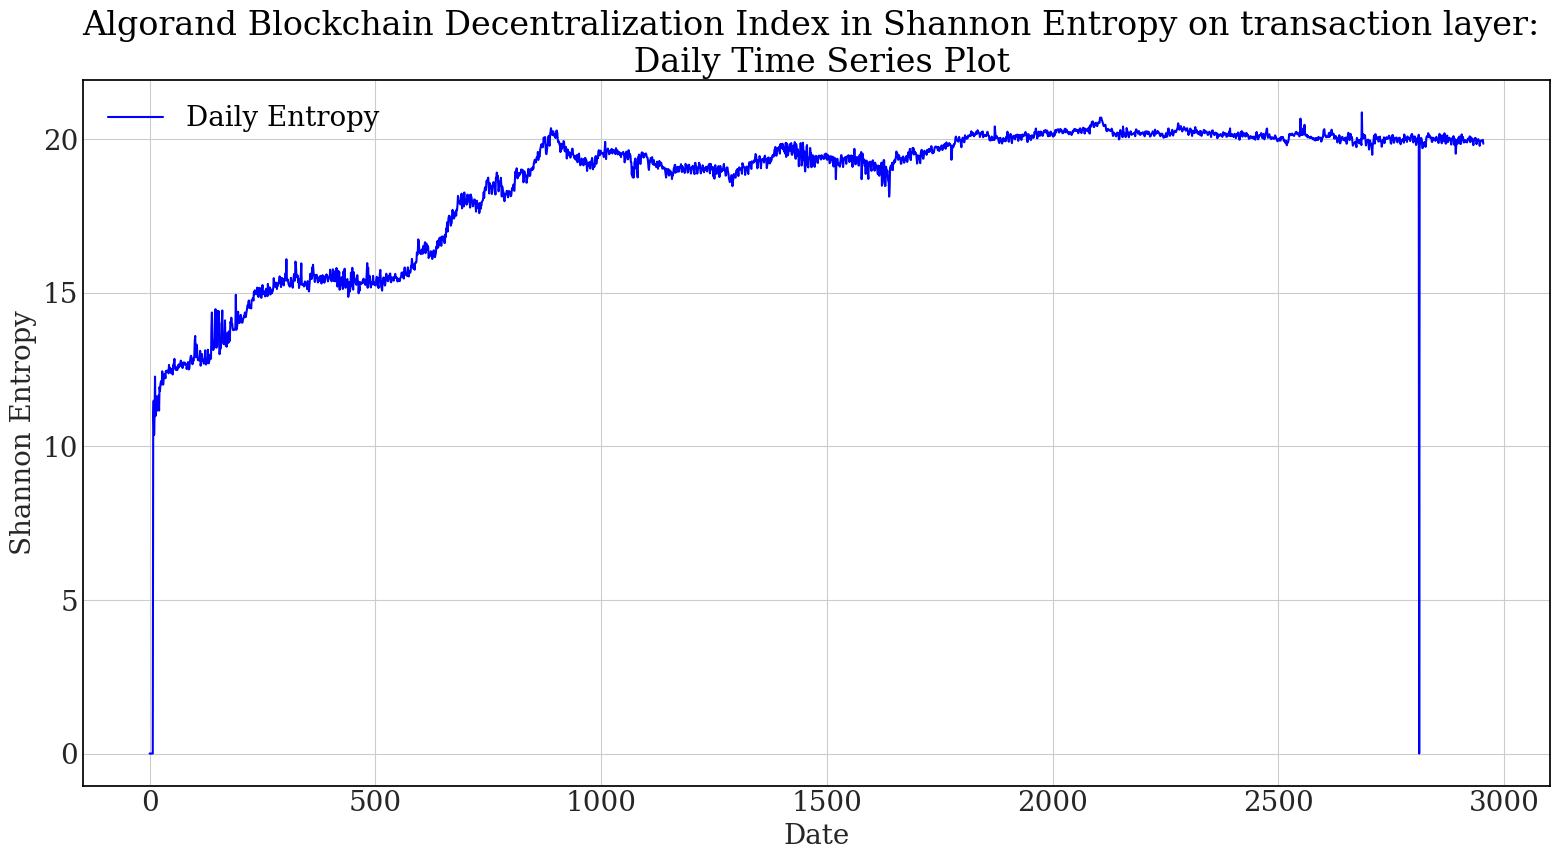

<Figure size 640x480 with 0 Axes>

In [82]:
#be_transact.set_index('Timestamp', inplace=True)

# Set the style to a scientific publication style
# Set font and font size globally using rcParams
plt.rcParams.update({
    'font.family': 'DejaVu Serif',  # Set the font family to DejaVu Serif
    'font.size': 20,  # Set the font size to 10 for better readability in two-column formats
    'text.color': 'black',  # Ensure text color is black for better contrast
    'axes.facecolor': 'white',  # Set the axes background color to white
    'figure.facecolor': 'white',  # Set the figure background color to white
    'axes.edgecolor': 'black',  # Set the axes edge color to black
})

# Create the time series plot
plt.figure(figsize=(16, 9))
plt.plot(be_transact.index, be_transact['entropy'], label='Daily Entropy',color='blue')

# Customize the plot
plt.title('Algorand Blockchain Decentralization Index in Shannon Entropy on transaction layer: \n Daily Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Shannon Entropy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('Beacon_trasac_entropy.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()
plt.tight_layout()
plt.show()